<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_tuning_with_mixup_best_of_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.7 MB/s eta 0:00:00


In [ ]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

In [ ]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW

In [ ]:
batch_size=96
epochs = 300
lr = 0.1*3e-4
gamma = 0.8
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=0.45,
    attn_drop_rate=0.35,
    drop_path_rate=0.35
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=6e-3
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=100,
    T_mult=2,
    eta_min=1e-7
)

学習ループを設定し、実行していく

In [ ]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=0.2)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            # Mixupを考慮した精度計算
            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()


        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-18-18b8802f1cca>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-18-18b8802f1cca>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7350 - acc: 0.4882 - val_loss : 0.8367 - val_acc: 0.3021 - test_loss : 0.7104 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7599 - acc: 0.4909 - val_loss : 0.7805 - val_acc: 0.3021 - test_loss : 0.6872 - test_acc: 0.5263



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7004 - acc: 0.4534 - val_loss : 0.7341 - val_acc: 0.3073 - test_loss : 0.6735 - test_acc: 0.5526



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6715 - acc: 0.5886 - val_loss : 0.7102 - val_acc: 0.4010 - test_loss : 0.6666 - test_acc: 0.6579



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7089 - acc: 0.4719 - val_loss : 0.6926 - val_acc: 0.4844 - test_loss : 0.6619 - test_acc: 0.6842



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6905 - acc: 0.5416 - val_loss : 0.6839 - val_acc: 0.5052 - test_loss : 0.6576 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6817 - acc: 0.5938 - val_loss : 0.6791 - val_acc: 0.5938 - test_loss : 0.6532 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6709 - acc: 0.6465 - val_loss : 0.6705 - val_acc: 0.6354 - test_loss : 0.6495 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6666 - acc: 0.6529 - val_loss : 0.6677 - val_acc: 0.6458 - test_loss : 0.6449 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6517 - acc: 0.6626 - val_loss : 0.6640 - val_acc: 0.6771 - test_loss : 0.6404 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6743 - acc: 0.5383 - val_loss : 0.6655 - val_acc: 0.6302 - test_loss : 0.6336 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6588 - acc: 0.6493 - val_loss : 0.6658 - val_acc: 0.6302 - test_loss : 0.6267 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6352 - acc: 0.6955 - val_loss : 0.6655 - val_acc: 0.6719 - test_loss : 0.6195 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.7083 - acc: 0.5574 - val_loss : 0.6570 - val_acc: 0.6771 - test_loss : 0.6161 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6260 - acc: 0.6885 - val_loss : 0.6491 - val_acc: 0.6719 - test_loss : 0.6125 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6801 - acc: 0.5726 - val_loss : 0.6461 - val_acc: 0.6667 - test_loss : 0.6073 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6348 - acc: 0.6496 - val_loss : 0.6438 - val_acc: 0.6615 - test_loss : 0.6023 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6347 - acc: 0.6473 - val_loss : 0.6427 - val_acc: 0.6667 - test_loss : 0.5976 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6417 - acc: 0.6678 - val_loss : 0.6571 - val_acc: 0.6719 - test_loss : 0.5888 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6317 - acc: 0.6809 - val_loss : 0.6718 - val_acc: 0.6354 - test_loss : 0.5827 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6068 - acc: 0.7228 - val_loss : 0.6610 - val_acc: 0.6875 - test_loss : 0.5800 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6282 - acc: 0.6627 - val_loss : 0.6445 - val_acc: 0.6719 - test_loss : 0.5811 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6218 - acc: 0.6886 - val_loss : 0.6293 - val_acc: 0.6771 - test_loss : 0.5854 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6257 - acc: 0.6462 - val_loss : 0.6244 - val_acc: 0.6771 - test_loss : 0.5849 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5954 - acc: 0.7289 - val_loss : 0.6276 - val_acc: 0.6667 - test_loss : 0.5791 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6061 - acc: 0.7110 - val_loss : 0.6268 - val_acc: 0.6667 - test_loss : 0.5753 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5713 - acc: 0.7153 - val_loss : 0.6214 - val_acc: 0.6667 - test_loss : 0.5742 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5899 - acc: 0.7211 - val_loss : 0.6188 - val_acc: 0.6667 - test_loss : 0.5710 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5610 - acc: 0.7186 - val_loss : 0.6201 - val_acc: 0.6719 - test_loss : 0.5649 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6368 - acc: 0.6810 - val_loss : 0.6135 - val_acc: 0.7135 - test_loss : 0.5642 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6152 - acc: 0.7037 - val_loss : 0.6053 - val_acc: 0.7292 - test_loss : 0.5681 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6024 - acc: 0.6922 - val_loss : 0.5992 - val_acc: 0.7135 - test_loss : 0.5707 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5550 - acc: 0.7743 - val_loss : 0.5984 - val_acc: 0.7188 - test_loss : 0.5659 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6020 - acc: 0.6813 - val_loss : 0.6129 - val_acc: 0.7188 - test_loss : 0.5499 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5698 - acc: 0.7319 - val_loss : 0.6373 - val_acc: 0.6458 - test_loss : 0.5378 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5929 - acc: 0.7056 - val_loss : 0.6342 - val_acc: 0.6406 - test_loss : 0.5344 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5965 - acc: 0.6967 - val_loss : 0.6150 - val_acc: 0.6771 - test_loss : 0.5344 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5667 - acc: 0.7113 - val_loss : 0.6019 - val_acc: 0.7188 - test_loss : 0.5335 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5473 - acc: 0.7523 - val_loss : 0.6040 - val_acc: 0.6875 - test_loss : 0.5269 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5830 - acc: 0.7677 - val_loss : 0.6225 - val_acc: 0.6146 - test_loss : 0.5185 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5683 - acc: 0.7461 - val_loss : 0.6465 - val_acc: 0.6198 - test_loss : 0.5135 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5902 - acc: 0.6899 - val_loss : 0.6525 - val_acc: 0.6302 - test_loss : 0.5106 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6475 - acc: 0.6324 - val_loss : 0.6455 - val_acc: 0.6198 - test_loss : 0.5071 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5645 - acc: 0.7269 - val_loss : 0.6427 - val_acc: 0.6198 - test_loss : 0.5042 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5501 - acc: 0.7462 - val_loss : 0.6385 - val_acc: 0.6198 - test_loss : 0.5016 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5606 - acc: 0.7355 - val_loss : 0.6291 - val_acc: 0.6198 - test_loss : 0.4989 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5676 - acc: 0.7221 - val_loss : 0.6111 - val_acc: 0.6250 - test_loss : 0.4978 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5815 - acc: 0.7383 - val_loss : 0.6093 - val_acc: 0.6250 - test_loss : 0.4985 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5282 - acc: 0.7705 - val_loss : 0.6138 - val_acc: 0.6250 - test_loss : 0.4996 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5571 - acc: 0.7385 - val_loss : 0.6331 - val_acc: 0.6250 - test_loss : 0.5026 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5785 - acc: 0.7385 - val_loss : 0.6571 - val_acc: 0.6458 - test_loss : 0.5080 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5473 - acc: 0.7441 - val_loss : 0.6546 - val_acc: 0.6406 - test_loss : 0.5091 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5673 - acc: 0.7246 - val_loss : 0.6423 - val_acc: 0.6354 - test_loss : 0.5084 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5689 - acc: 0.7262 - val_loss : 0.6215 - val_acc: 0.6198 - test_loss : 0.5080 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5498 - acc: 0.7631 - val_loss : 0.6072 - val_acc: 0.6719 - test_loss : 0.5095 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5230 - acc: 0.7638 - val_loss : 0.6012 - val_acc: 0.6771 - test_loss : 0.5115 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5931 - acc: 0.7322 - val_loss : 0.5978 - val_acc: 0.6667 - test_loss : 0.5138 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5256 - acc: 0.7724 - val_loss : 0.5967 - val_acc: 0.6667 - test_loss : 0.5141 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5777 - acc: 0.7499 - val_loss : 0.5948 - val_acc: 0.6667 - test_loss : 0.5157 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5206 - acc: 0.7702 - val_loss : 0.5999 - val_acc: 0.6615 - test_loss : 0.5160 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5996 - acc: 0.6852 - val_loss : 0.6069 - val_acc: 0.6719 - test_loss : 0.5166 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5137 - acc: 0.7600 - val_loss : 0.6097 - val_acc: 0.6719 - test_loss : 0.5173 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5636 - acc: 0.7363 - val_loss : 0.6061 - val_acc: 0.6719 - test_loss : 0.5186 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5500 - acc: 0.7569 - val_loss : 0.5971 - val_acc: 0.6979 - test_loss : 0.5206 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5357 - acc: 0.7662 - val_loss : 0.5910 - val_acc: 0.7448 - test_loss : 0.5221 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5971 - acc: 0.6787 - val_loss : 0.5874 - val_acc: 0.7552 - test_loss : 0.5231 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5344 - acc: 0.7606 - val_loss : 0.5866 - val_acc: 0.7500 - test_loss : 0.5231 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.4958 - acc: 0.8095 - val_loss : 0.5852 - val_acc: 0.7500 - test_loss : 0.5224 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5091 - acc: 0.7986 - val_loss : 0.5863 - val_acc: 0.7135 - test_loss : 0.5203 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5294 - acc: 0.7465 - val_loss : 0.5888 - val_acc: 0.7083 - test_loss : 0.5173 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5349 - acc: 0.7920 - val_loss : 0.5920 - val_acc: 0.7031 - test_loss : 0.5143 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5207 - acc: 0.8064 - val_loss : 0.5938 - val_acc: 0.7083 - test_loss : 0.5119 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5873 - acc: 0.7221 - val_loss : 0.5894 - val_acc: 0.7083 - test_loss : 0.5122 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5101 - acc: 0.7738 - val_loss : 0.5855 - val_acc: 0.7135 - test_loss : 0.5121 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.4986 - acc: 0.8099 - val_loss : 0.5823 - val_acc: 0.7135 - test_loss : 0.5119 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5921 - acc: 0.7184 - val_loss : 0.5810 - val_acc: 0.7135 - test_loss : 0.5119 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5519 - acc: 0.7238 - val_loss : 0.5802 - val_acc: 0.7135 - test_loss : 0.5121 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5445 - acc: 0.7652 - val_loss : 0.5798 - val_acc: 0.7135 - test_loss : 0.5120 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5098 - acc: 0.7957 - val_loss : 0.5803 - val_acc: 0.7135 - test_loss : 0.5115 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.5437 - acc: 0.7883 - val_loss : 0.5802 - val_acc: 0.7135 - test_loss : 0.5111 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4634 - acc: 0.8306 - val_loss : 0.5797 - val_acc: 0.7135 - test_loss : 0.5105 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.5291 - acc: 0.7691 - val_loss : 0.5796 - val_acc: 0.7135 - test_loss : 0.5100 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.4923 - acc: 0.7845 - val_loss : 0.5793 - val_acc: 0.7135 - test_loss : 0.5096 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5590 - acc: 0.7839 - val_loss : 0.5799 - val_acc: 0.7135 - test_loss : 0.5090 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.6001 - acc: 0.7041 - val_loss : 0.5803 - val_acc: 0.7135 - test_loss : 0.5085 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.4965 - acc: 0.7950 - val_loss : 0.5804 - val_acc: 0.7135 - test_loss : 0.5081 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5052 - acc: 0.7736 - val_loss : 0.5802 - val_acc: 0.7135 - test_loss : 0.5078 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.5573 - acc: 0.7324 - val_loss : 0.5796 - val_acc: 0.7135 - test_loss : 0.5078 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.4988 - acc: 0.8124 - val_loss : 0.5791 - val_acc: 0.7135 - test_loss : 0.5077 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5053 - acc: 0.7788 - val_loss : 0.5789 - val_acc: 0.7135 - test_loss : 0.5075 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5589 - acc: 0.6819 - val_loss : 0.5787 - val_acc: 0.7135 - test_loss : 0.5073 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.5165 - acc: 0.7674 - val_loss : 0.5786 - val_acc: 0.7135 - test_loss : 0.5070 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5145 - acc: 0.7954 - val_loss : 0.5784 - val_acc: 0.7135 - test_loss : 0.5070 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5135 - acc: 0.7509 - val_loss : 0.5782 - val_acc: 0.7135 - test_loss : 0.5069 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5615 - acc: 0.7560 - val_loss : 0.5783 - val_acc: 0.7135 - test_loss : 0.5067 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5858 - acc: 0.7096 - val_loss : 0.5783 - val_acc: 0.7135 - test_loss : 0.5067 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5379 - acc: 0.7878 - val_loss : 0.5783 - val_acc: 0.7135 - test_loss : 0.5066 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5293 - acc: 0.7624 - val_loss : 0.5783 - val_acc: 0.7135 - test_loss : 0.5066 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5264 - acc: 0.8041 - val_loss : 0.5784 - val_acc: 0.7135 - test_loss : 0.5066 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5362 - acc: 0.7671 - val_loss : 0.5784 - val_acc: 0.7135 - test_loss : 0.5067 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5358 - acc: 0.7788 - val_loss : 0.5882 - val_acc: 0.7083 - test_loss : 0.5044 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.5679 - acc: 0.7550 - val_loss : 0.5713 - val_acc: 0.7552 - test_loss : 0.5111 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.4995 - acc: 0.7975 - val_loss : 0.5586 - val_acc: 0.7292 - test_loss : 0.5186 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.5329 - acc: 0.7805 - val_loss : 0.5768 - val_acc: 0.7552 - test_loss : 0.5082 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.5029 - acc: 0.7761 - val_loss : 0.5728 - val_acc: 0.7500 - test_loss : 0.5043 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.4904 - acc: 0.8081 - val_loss : 0.5484 - val_acc: 0.7344 - test_loss : 0.5064 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.5090 - acc: 0.8005 - val_loss : 0.5299 - val_acc: 0.7708 - test_loss : 0.5119 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.4718 - acc: 0.7813 - val_loss : 0.5203 - val_acc: 0.8125 - test_loss : 0.5076 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.4557 - acc: 0.7978 - val_loss : 0.5384 - val_acc: 0.7552 - test_loss : 0.4812 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.5228 - acc: 0.7539 - val_loss : 0.5457 - val_acc: 0.7604 - test_loss : 0.4736 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.5504 - acc: 0.7329 - val_loss : 0.5131 - val_acc: 0.7865 - test_loss : 0.4841 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.4650 - acc: 0.8261 - val_loss : 0.4967 - val_acc: 0.8385 - test_loss : 0.5254 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.5479 - acc: 0.7305 - val_loss : 0.4946 - val_acc: 0.8385 - test_loss : 0.5200 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.5260 - acc: 0.7890 - val_loss : 0.5080 - val_acc: 0.7500 - test_loss : 0.4739 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.5516 - acc: 0.7755 - val_loss : 0.5136 - val_acc: 0.7604 - test_loss : 0.4726 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.5045 - acc: 0.8122 - val_loss : 0.5001 - val_acc: 0.8177 - test_loss : 0.4920 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.4600 - acc: 0.8327 - val_loss : 0.4972 - val_acc: 0.8385 - test_loss : 0.5156 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.5863 - acc: 0.7172 - val_loss : 0.4999 - val_acc: 0.8281 - test_loss : 0.5220 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.4824 - acc: 0.8177 - val_loss : 0.5034 - val_acc: 0.8490 - test_loss : 0.5136 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.4267 - acc: 0.8527 - val_loss : 0.5102 - val_acc: 0.8177 - test_loss : 0.4998 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.5130 - acc: 0.7857 - val_loss : 0.5158 - val_acc: 0.7865 - test_loss : 0.4956 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.5442 - acc: 0.7691 - val_loss : 0.5141 - val_acc: 0.8177 - test_loss : 0.5011 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.4654 - acc: 0.8265 - val_loss : 0.5079 - val_acc: 0.8542 - test_loss : 0.5174 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.4903 - acc: 0.8082 - val_loss : 0.5098 - val_acc: 0.8542 - test_loss : 0.5125 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.5811 - acc: 0.7450 - val_loss : 0.5278 - val_acc: 0.7396 - test_loss : 0.4962 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.4804 - acc: 0.8127 - val_loss : 0.5479 - val_acc: 0.7448 - test_loss : 0.4917 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.4972 - acc: 0.7874 - val_loss : 0.5356 - val_acc: 0.7500 - test_loss : 0.4911 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.4972 - acc: 0.7762 - val_loss : 0.5151 - val_acc: 0.8073 - test_loss : 0.4965 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.5201 - acc: 0.7810 - val_loss : 0.5170 - val_acc: 0.7240 - test_loss : 0.4888 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.5917 - acc: 0.7062 - val_loss : 0.5380 - val_acc: 0.7552 - test_loss : 0.4812 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.4995 - acc: 0.7807 - val_loss : 0.5488 - val_acc: 0.7552 - test_loss : 0.4792 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.4869 - acc: 0.7918 - val_loss : 0.5425 - val_acc: 0.7500 - test_loss : 0.4757 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.4768 - acc: 0.8348 - val_loss : 0.5328 - val_acc: 0.7396 - test_loss : 0.4745 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.4094 - acc: 0.8765 - val_loss : 0.5375 - val_acc: 0.7500 - test_loss : 0.4722 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.5908 - acc: 0.7122 - val_loss : 0.5173 - val_acc: 0.7396 - test_loss : 0.4716 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.4776 - acc: 0.8378 - val_loss : 0.5144 - val_acc: 0.7396 - test_loss : 0.4693 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.4789 - acc: 0.8284 - val_loss : 0.5373 - val_acc: 0.7500 - test_loss : 0.4706 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.4309 - acc: 0.8360 - val_loss : 0.5375 - val_acc: 0.7448 - test_loss : 0.4720 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.4825 - acc: 0.7847 - val_loss : 0.5028 - val_acc: 0.8073 - test_loss : 0.4765 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.4574 - acc: 0.8188 - val_loss : 0.4981 - val_acc: 0.8125 - test_loss : 0.4856 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.4295 - acc: 0.8513 - val_loss : 0.5058 - val_acc: 0.7656 - test_loss : 0.4749 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.4518 - acc: 0.8397 - val_loss : 0.5213 - val_acc: 0.7760 - test_loss : 0.4696 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.5246 - acc: 0.7734 - val_loss : 0.5107 - val_acc: 0.7760 - test_loss : 0.4700 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.4674 - acc: 0.8018 - val_loss : 0.5006 - val_acc: 0.7656 - test_loss : 0.4741 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.3921 - acc: 0.8698 - val_loss : 0.4952 - val_acc: 0.8490 - test_loss : 0.4811 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.4179 - acc: 0.8525 - val_loss : 0.5001 - val_acc: 0.7604 - test_loss : 0.4698 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.3645 - acc: 0.8953 - val_loss : 0.5150 - val_acc: 0.7812 - test_loss : 0.4666 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.5017 - acc: 0.8000 - val_loss : 0.5154 - val_acc: 0.7812 - test_loss : 0.4670 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.5376 - acc: 0.7616 - val_loss : 0.5441 - val_acc: 0.7396 - test_loss : 0.4757 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.4774 - acc: 0.8124 - val_loss : 0.5268 - val_acc: 0.7396 - test_loss : 0.4705 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.4538 - acc: 0.8451 - val_loss : 0.5128 - val_acc: 0.7396 - test_loss : 0.4723 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.5514 - acc: 0.7660 - val_loss : 0.5109 - val_acc: 0.7656 - test_loss : 0.4767 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.3666 - acc: 0.9059 - val_loss : 0.5089 - val_acc: 0.8073 - test_loss : 0.4791 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.4710 - acc: 0.8491 - val_loss : 0.5224 - val_acc: 0.7396 - test_loss : 0.4799 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.4285 - acc: 0.8713 - val_loss : 0.5196 - val_acc: 0.7448 - test_loss : 0.4817 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.4557 - acc: 0.8264 - val_loss : 0.4997 - val_acc: 0.8021 - test_loss : 0.4869 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.3699 - acc: 0.9128 - val_loss : 0.4969 - val_acc: 0.8073 - test_loss : 0.4892 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.5667 - acc: 0.7289 - val_loss : 0.5054 - val_acc: 0.8229 - test_loss : 0.4846 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.4181 - acc: 0.8774 - val_loss : 0.5462 - val_acc: 0.7552 - test_loss : 0.4942 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.4844 - acc: 0.7750 - val_loss : 0.5405 - val_acc: 0.7500 - test_loss : 0.4940 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.4822 - acc: 0.8037 - val_loss : 0.5026 - val_acc: 0.7917 - test_loss : 0.4845 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.4653 - acc: 0.8057 - val_loss : 0.5011 - val_acc: 0.7917 - test_loss : 0.4842 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.3724 - acc: 0.8932 - val_loss : 0.4978 - val_acc: 0.7969 - test_loss : 0.4822 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.4388 - acc: 0.8580 - val_loss : 0.4870 - val_acc: 0.8281 - test_loss : 0.4815 - test_acc: 0.7368



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.3854 - acc: 0.9028 - val_loss : 0.4796 - val_acc: 0.8333 - test_loss : 0.4806 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.4221 - acc: 0.8588 - val_loss : 0.4740 - val_acc: 0.8333 - test_loss : 0.4745 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.4191 - acc: 0.8558 - val_loss : 0.4701 - val_acc: 0.8542 - test_loss : 0.4672 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.4583 - acc: 0.8146 - val_loss : 0.4601 - val_acc: 0.8438 - test_loss : 0.4645 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.3600 - acc: 0.9228 - val_loss : 0.4553 - val_acc: 0.8594 - test_loss : 0.4709 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.3824 - acc: 0.8988 - val_loss : 0.4506 - val_acc: 0.8229 - test_loss : 0.4566 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.4161 - acc: 0.8665 - val_loss : 0.4599 - val_acc: 0.8073 - test_loss : 0.4388 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.5755 - acc: 0.7444 - val_loss : 0.4572 - val_acc: 0.8073 - test_loss : 0.4339 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.4284 - acc: 0.8311 - val_loss : 0.4453 - val_acc: 0.8333 - test_loss : 0.4410 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.3709 - acc: 0.8977 - val_loss : 0.4496 - val_acc: 0.8177 - test_loss : 0.4516 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.4547 - acc: 0.8251 - val_loss : 0.4494 - val_acc: 0.8385 - test_loss : 0.4393 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.5962 - acc: 0.7360 - val_loss : 0.4534 - val_acc: 0.8490 - test_loss : 0.4433 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.4161 - acc: 0.8785 - val_loss : 0.4543 - val_acc: 0.8281 - test_loss : 0.4524 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.3921 - acc: 0.8812 - val_loss : 0.4580 - val_acc: 0.8177 - test_loss : 0.4655 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.4765 - acc: 0.8076 - val_loss : 0.4611 - val_acc: 0.8177 - test_loss : 0.4743 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.5194 - acc: 0.7808 - val_loss : 0.4622 - val_acc: 0.8229 - test_loss : 0.4688 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.5951 - acc: 0.7118 - val_loss : 0.4679 - val_acc: 0.8438 - test_loss : 0.4689 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.3424 - acc: 0.9131 - val_loss : 0.4657 - val_acc: 0.8333 - test_loss : 0.4723 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.3782 - acc: 0.9287 - val_loss : 0.4622 - val_acc: 0.8229 - test_loss : 0.4724 - test_acc: 0.7632



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.3982 - acc: 0.8843 - val_loss : 0.4611 - val_acc: 0.8646 - test_loss : 0.4777 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.4443 - acc: 0.8511 - val_loss : 0.4617 - val_acc: 0.8594 - test_loss : 0.4801 - test_acc: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.3959 - acc: 0.8941 - val_loss : 0.4542 - val_acc: 0.8229 - test_loss : 0.4573 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.3675 - acc: 0.9082 - val_loss : 0.4523 - val_acc: 0.8333 - test_loss : 0.4417 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.4126 - acc: 0.8547 - val_loss : 0.4474 - val_acc: 0.8333 - test_loss : 0.4353 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.3645 - acc: 0.8968 - val_loss : 0.4410 - val_acc: 0.8438 - test_loss : 0.4284 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.4456 - acc: 0.8261 - val_loss : 0.4356 - val_acc: 0.8490 - test_loss : 0.4220 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.3535 - acc: 0.8745 - val_loss : 0.4315 - val_acc: 0.8438 - test_loss : 0.4188 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.3587 - acc: 0.9050 - val_loss : 0.4305 - val_acc: 0.8438 - test_loss : 0.4148 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.4042 - acc: 0.8925 - val_loss : 0.4291 - val_acc: 0.8490 - test_loss : 0.4100 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.3726 - acc: 0.8811 - val_loss : 0.4301 - val_acc: 0.8646 - test_loss : 0.4053 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.4461 - acc: 0.8400 - val_loss : 0.4359 - val_acc: 0.8542 - test_loss : 0.4067 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.4747 - acc: 0.8180 - val_loss : 0.4409 - val_acc: 0.8646 - test_loss : 0.4074 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.4637 - acc: 0.8236 - val_loss : 0.4359 - val_acc: 0.8542 - test_loss : 0.4006 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.3911 - acc: 0.8892 - val_loss : 0.4313 - val_acc: 0.8594 - test_loss : 0.3935 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.4075 - acc: 0.8845 - val_loss : 0.4333 - val_acc: 0.8594 - test_loss : 0.3912 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.5330 - acc: 0.7681 - val_loss : 0.4412 - val_acc: 0.8542 - test_loss : 0.3977 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 201 - loss : 0.3086 - acc: 0.9164 - val_loss : 0.4607 - val_acc: 0.8125 - test_loss : 0.4157 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 202 - loss : 0.4112 - acc: 0.8619 - val_loss : 0.4646 - val_acc: 0.8177 - test_loss : 0.4194 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 203 - loss : 0.4082 - acc: 0.8788 - val_loss : 0.4470 - val_acc: 0.8177 - test_loss : 0.4066 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 204 - loss : 0.4496 - acc: 0.8243 - val_loss : 0.4389 - val_acc: 0.8646 - test_loss : 0.3993 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 205 - loss : 0.4007 - acc: 0.8693 - val_loss : 0.4349 - val_acc: 0.8594 - test_loss : 0.3950 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 206 - loss : 0.5107 - acc: 0.8005 - val_loss : 0.4328 - val_acc: 0.8646 - test_loss : 0.3942 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 207 - loss : 0.3880 - acc: 0.9055 - val_loss : 0.4340 - val_acc: 0.8646 - test_loss : 0.3989 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 208 - loss : 0.4474 - acc: 0.8529 - val_loss : 0.4397 - val_acc: 0.8646 - test_loss : 0.4087 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 209 - loss : 0.3513 - acc: 0.9210 - val_loss : 0.4469 - val_acc: 0.8646 - test_loss : 0.4167 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 210 - loss : 0.4624 - acc: 0.8338 - val_loss : 0.4483 - val_acc: 0.8646 - test_loss : 0.4181 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 211 - loss : 0.3468 - acc: 0.9036 - val_loss : 0.4391 - val_acc: 0.8698 - test_loss : 0.4082 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 212 - loss : 0.4377 - acc: 0.8228 - val_loss : 0.4338 - val_acc: 0.8594 - test_loss : 0.3997 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 213 - loss : 0.4377 - acc: 0.8456 - val_loss : 0.4332 - val_acc: 0.8594 - test_loss : 0.3969 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 214 - loss : 0.4180 - acc: 0.8656 - val_loss : 0.4344 - val_acc: 0.8594 - test_loss : 0.3970 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 215 - loss : 0.3545 - acc: 0.9105 - val_loss : 0.4383 - val_acc: 0.8698 - test_loss : 0.4004 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 216 - loss : 0.4460 - acc: 0.8301 - val_loss : 0.4468 - val_acc: 0.8646 - test_loss : 0.4071 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 217 - loss : 0.4063 - acc: 0.8509 - val_loss : 0.4538 - val_acc: 0.8542 - test_loss : 0.4122 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 218 - loss : 0.4479 - acc: 0.8453 - val_loss : 0.4502 - val_acc: 0.8646 - test_loss : 0.4075 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 219 - loss : 0.3260 - acc: 0.9480 - val_loss : 0.4405 - val_acc: 0.8646 - test_loss : 0.3967 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 220 - loss : 0.3060 - acc: 0.9413 - val_loss : 0.4370 - val_acc: 0.8646 - test_loss : 0.3914 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 221 - loss : 0.3796 - acc: 0.9152 - val_loss : 0.4389 - val_acc: 0.8542 - test_loss : 0.3911 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 222 - loss : 0.5205 - acc: 0.7833 - val_loss : 0.4411 - val_acc: 0.8646 - test_loss : 0.3924 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 223 - loss : 0.5173 - acc: 0.7914 - val_loss : 0.4504 - val_acc: 0.8542 - test_loss : 0.4009 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 224 - loss : 0.3702 - acc: 0.8856 - val_loss : 0.4602 - val_acc: 0.8594 - test_loss : 0.4078 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 225 - loss : 0.3756 - acc: 0.8896 - val_loss : 0.4631 - val_acc: 0.8594 - test_loss : 0.4073 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 226 - loss : 0.3694 - acc: 0.8981 - val_loss : 0.4607 - val_acc: 0.8594 - test_loss : 0.4024 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 227 - loss : 0.4632 - acc: 0.8300 - val_loss : 0.4564 - val_acc: 0.8490 - test_loss : 0.3966 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 228 - loss : 0.3194 - acc: 0.9420 - val_loss : 0.4523 - val_acc: 0.8542 - test_loss : 0.3923 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 229 - loss : 0.3954 - acc: 0.8737 - val_loss : 0.4490 - val_acc: 0.8542 - test_loss : 0.3889 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 230 - loss : 0.4683 - acc: 0.8369 - val_loss : 0.4462 - val_acc: 0.8594 - test_loss : 0.3873 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 231 - loss : 0.4111 - acc: 0.8708 - val_loss : 0.4444 - val_acc: 0.8542 - test_loss : 0.3872 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 232 - loss : 0.3272 - acc: 0.9328 - val_loss : 0.4423 - val_acc: 0.8542 - test_loss : 0.3875 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 233 - loss : 0.4652 - acc: 0.8190 - val_loss : 0.4396 - val_acc: 0.8542 - test_loss : 0.3877 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 234 - loss : 0.3906 - acc: 0.8748 - val_loss : 0.4384 - val_acc: 0.8542 - test_loss : 0.3901 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 235 - loss : 0.3275 - acc: 0.9289 - val_loss : 0.4363 - val_acc: 0.8542 - test_loss : 0.3901 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 236 - loss : 0.5060 - acc: 0.8107 - val_loss : 0.4339 - val_acc: 0.8594 - test_loss : 0.3889 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 237 - loss : 0.4435 - acc: 0.8295 - val_loss : 0.4323 - val_acc: 0.8594 - test_loss : 0.3876 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 238 - loss : 0.4530 - acc: 0.8400 - val_loss : 0.4313 - val_acc: 0.8542 - test_loss : 0.3871 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 239 - loss : 0.5041 - acc: 0.7778 - val_loss : 0.4305 - val_acc: 0.8490 - test_loss : 0.3875 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 240 - loss : 0.4804 - acc: 0.8085 - val_loss : 0.4302 - val_acc: 0.8542 - test_loss : 0.3873 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 241 - loss : 0.3377 - acc: 0.9331 - val_loss : 0.4300 - val_acc: 0.8594 - test_loss : 0.3878 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 242 - loss : 0.3589 - acc: 0.9226 - val_loss : 0.4288 - val_acc: 0.8542 - test_loss : 0.3882 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 243 - loss : 0.4171 - acc: 0.8754 - val_loss : 0.4275 - val_acc: 0.8542 - test_loss : 0.3883 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 244 - loss : 0.3229 - acc: 0.9496 - val_loss : 0.4270 - val_acc: 0.8542 - test_loss : 0.3876 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 245 - loss : 0.3065 - acc: 0.9382 - val_loss : 0.4268 - val_acc: 0.8542 - test_loss : 0.3869 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 246 - loss : 0.3579 - acc: 0.9245 - val_loss : 0.4273 - val_acc: 0.8594 - test_loss : 0.3871 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 247 - loss : 0.5654 - acc: 0.7248 - val_loss : 0.4282 - val_acc: 0.8646 - test_loss : 0.3885 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 248 - loss : 0.3735 - acc: 0.9242 - val_loss : 0.4304 - val_acc: 0.8594 - test_loss : 0.3908 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 249 - loss : 0.3952 - acc: 0.9007 - val_loss : 0.4313 - val_acc: 0.8594 - test_loss : 0.3899 - test_acc: 0.8684



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 250 - loss : 0.3740 - acc: 0.8949 - val_loss : 0.4317 - val_acc: 0.8594 - test_loss : 0.3887 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 251 - loss : 0.3924 - acc: 0.9015 - val_loss : 0.4318 - val_acc: 0.8698 - test_loss : 0.3875 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 252 - loss : 0.4088 - acc: 0.8801 - val_loss : 0.4315 - val_acc: 0.8646 - test_loss : 0.3857 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 253 - loss : 0.4594 - acc: 0.8449 - val_loss : 0.4315 - val_acc: 0.8594 - test_loss : 0.3846 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 254 - loss : 0.3603 - acc: 0.9104 - val_loss : 0.4320 - val_acc: 0.8646 - test_loss : 0.3844 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 255 - loss : 0.3177 - acc: 0.9534 - val_loss : 0.4332 - val_acc: 0.8698 - test_loss : 0.3852 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 256 - loss : 0.4036 - acc: 0.8866 - val_loss : 0.4346 - val_acc: 0.8646 - test_loss : 0.3866 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 257 - loss : 0.3907 - acc: 0.8938 - val_loss : 0.4362 - val_acc: 0.8594 - test_loss : 0.3884 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 258 - loss : 0.3040 - acc: 0.9507 - val_loss : 0.4372 - val_acc: 0.8594 - test_loss : 0.3892 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 259 - loss : 0.4262 - acc: 0.8648 - val_loss : 0.4375 - val_acc: 0.8594 - test_loss : 0.3892 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 260 - loss : 0.3183 - acc: 0.9364 - val_loss : 0.4374 - val_acc: 0.8594 - test_loss : 0.3892 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 261 - loss : 0.4282 - acc: 0.8642 - val_loss : 0.4384 - val_acc: 0.8594 - test_loss : 0.3905 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 262 - loss : 0.4655 - acc: 0.8282 - val_loss : 0.4390 - val_acc: 0.8594 - test_loss : 0.3919 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 263 - loss : 0.4157 - acc: 0.8521 - val_loss : 0.4384 - val_acc: 0.8594 - test_loss : 0.3918 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 264 - loss : 0.4191 - acc: 0.8707 - val_loss : 0.4378 - val_acc: 0.8594 - test_loss : 0.3914 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 265 - loss : 0.4238 - acc: 0.8647 - val_loss : 0.4373 - val_acc: 0.8594 - test_loss : 0.3904 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 266 - loss : 0.3023 - acc: 0.9431 - val_loss : 0.4360 - val_acc: 0.8594 - test_loss : 0.3892 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 267 - loss : 0.4314 - acc: 0.8402 - val_loss : 0.4356 - val_acc: 0.8594 - test_loss : 0.3892 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 268 - loss : 0.3772 - acc: 0.8970 - val_loss : 0.4352 - val_acc: 0.8594 - test_loss : 0.3891 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 269 - loss : 0.3409 - acc: 0.9260 - val_loss : 0.4350 - val_acc: 0.8594 - test_loss : 0.3893 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 270 - loss : 0.3369 - acc: 0.9222 - val_loss : 0.4350 - val_acc: 0.8594 - test_loss : 0.3898 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 271 - loss : 0.4250 - acc: 0.8395 - val_loss : 0.4354 - val_acc: 0.8594 - test_loss : 0.3911 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 272 - loss : 0.3333 - acc: 0.9222 - val_loss : 0.4360 - val_acc: 0.8594 - test_loss : 0.3922 - test_acc: 0.8158



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 273 - loss : 0.3702 - acc: 0.9096 - val_loss : 0.4367 - val_acc: 0.8594 - test_loss : 0.3938 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 274 - loss : 0.3932 - acc: 0.8781 - val_loss : 0.4378 - val_acc: 0.8594 - test_loss : 0.3955 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 275 - loss : 0.3846 - acc: 0.8869 - val_loss : 0.4387 - val_acc: 0.8542 - test_loss : 0.3970 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 276 - loss : 0.4280 - acc: 0.8626 - val_loss : 0.4395 - val_acc: 0.8542 - test_loss : 0.3982 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 277 - loss : 0.4233 - acc: 0.8616 - val_loss : 0.4404 - val_acc: 0.8542 - test_loss : 0.3996 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 278 - loss : 0.3355 - acc: 0.9150 - val_loss : 0.4407 - val_acc: 0.8542 - test_loss : 0.4003 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 279 - loss : 0.3017 - acc: 0.9481 - val_loss : 0.4408 - val_acc: 0.8542 - test_loss : 0.4007 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 280 - loss : 0.3226 - acc: 0.9430 - val_loss : 0.4401 - val_acc: 0.8542 - test_loss : 0.4004 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 281 - loss : 0.4503 - acc: 0.8343 - val_loss : 0.4401 - val_acc: 0.8542 - test_loss : 0.4004 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 282 - loss : 0.3502 - acc: 0.9184 - val_loss : 0.4394 - val_acc: 0.8542 - test_loss : 0.3999 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 283 - loss : 0.5232 - acc: 0.8067 - val_loss : 0.4385 - val_acc: 0.8542 - test_loss : 0.3994 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 284 - loss : 0.3567 - acc: 0.9138 - val_loss : 0.4380 - val_acc: 0.8542 - test_loss : 0.3991 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 285 - loss : 0.2920 - acc: 0.9647 - val_loss : 0.4371 - val_acc: 0.8542 - test_loss : 0.3984 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 286 - loss : 0.3965 - acc: 0.8508 - val_loss : 0.4360 - val_acc: 0.8594 - test_loss : 0.3973 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 287 - loss : 0.4199 - acc: 0.8656 - val_loss : 0.4351 - val_acc: 0.8594 - test_loss : 0.3966 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 288 - loss : 0.3672 - acc: 0.8641 - val_loss : 0.4344 - val_acc: 0.8594 - test_loss : 0.3959 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 289 - loss : 0.4678 - acc: 0.8195 - val_loss : 0.4340 - val_acc: 0.8594 - test_loss : 0.3955 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 290 - loss : 0.3721 - acc: 0.9035 - val_loss : 0.4337 - val_acc: 0.8594 - test_loss : 0.3954 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 291 - loss : 0.4709 - acc: 0.8042 - val_loss : 0.4336 - val_acc: 0.8594 - test_loss : 0.3954 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 292 - loss : 0.4607 - acc: 0.8278 - val_loss : 0.4336 - val_acc: 0.8594 - test_loss : 0.3954 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 293 - loss : 0.3527 - acc: 0.9296 - val_loss : 0.4336 - val_acc: 0.8594 - test_loss : 0.3954 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 294 - loss : 0.4103 - acc: 0.8672 - val_loss : 0.4334 - val_acc: 0.8594 - test_loss : 0.3953 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 295 - loss : 0.5425 - acc: 0.7446 - val_loss : 0.4333 - val_acc: 0.8594 - test_loss : 0.3951 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 296 - loss : 0.3099 - acc: 0.9437 - val_loss : 0.4331 - val_acc: 0.8594 - test_loss : 0.3950 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 297 - loss : 0.3589 - acc: 0.8938 - val_loss : 0.4329 - val_acc: 0.8594 - test_loss : 0.3948 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 298 - loss : 0.4916 - acc: 0.8158 - val_loss : 0.4329 - val_acc: 0.8594 - test_loss : 0.3947 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 299 - loss : 0.4194 - acc: 0.8669 - val_loss : 0.4329 - val_acc: 0.8594 - test_loss : 0.3946 - test_acc: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 300 - loss : 0.3501 - acc: 0.9235 - val_loss : 0.4329 - val_acc: 0.8594 - test_loss : 0.3946 - test_acc: 0.8421



# 学習結果の可視化

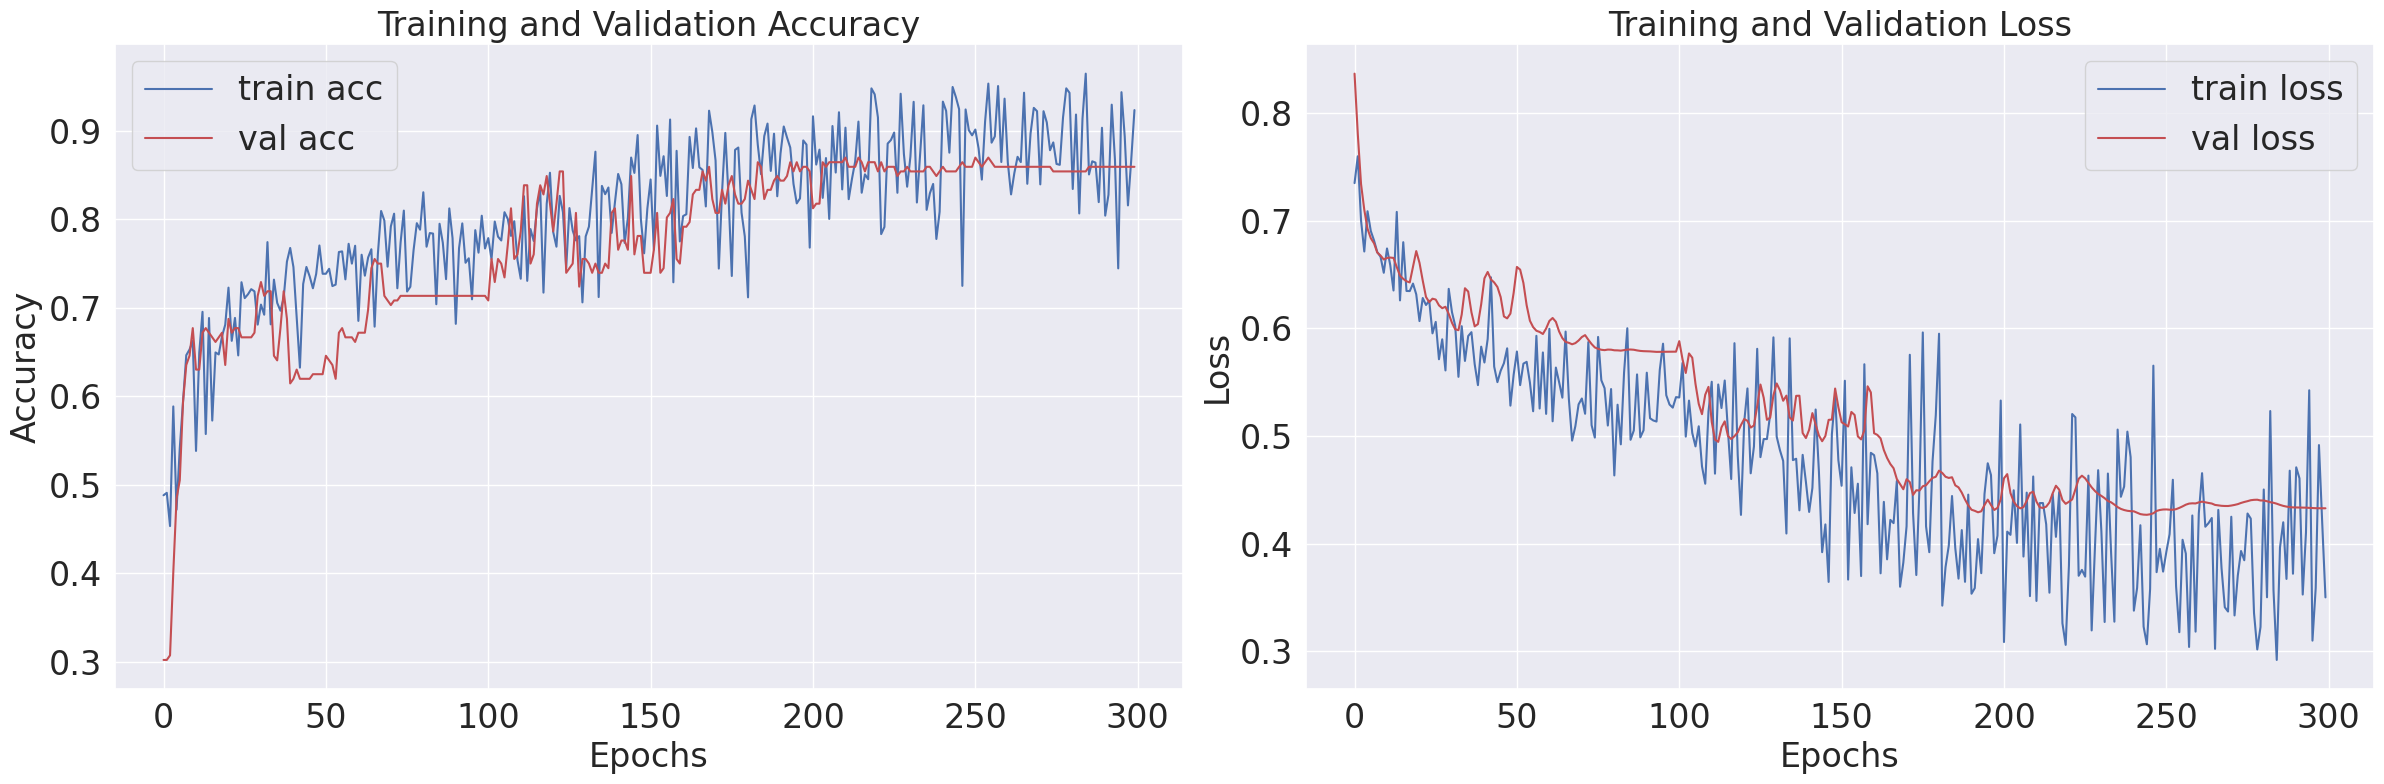

In [ ]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint'
torch.save(model.state_dict(), model_save_path)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9107


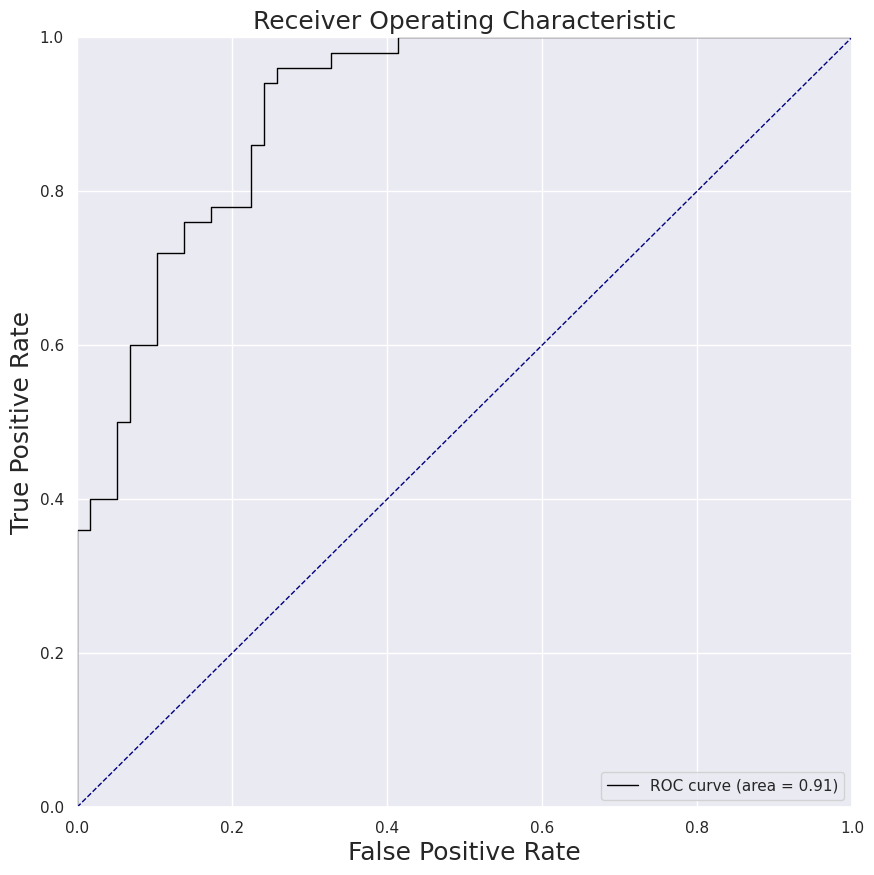

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [ ]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

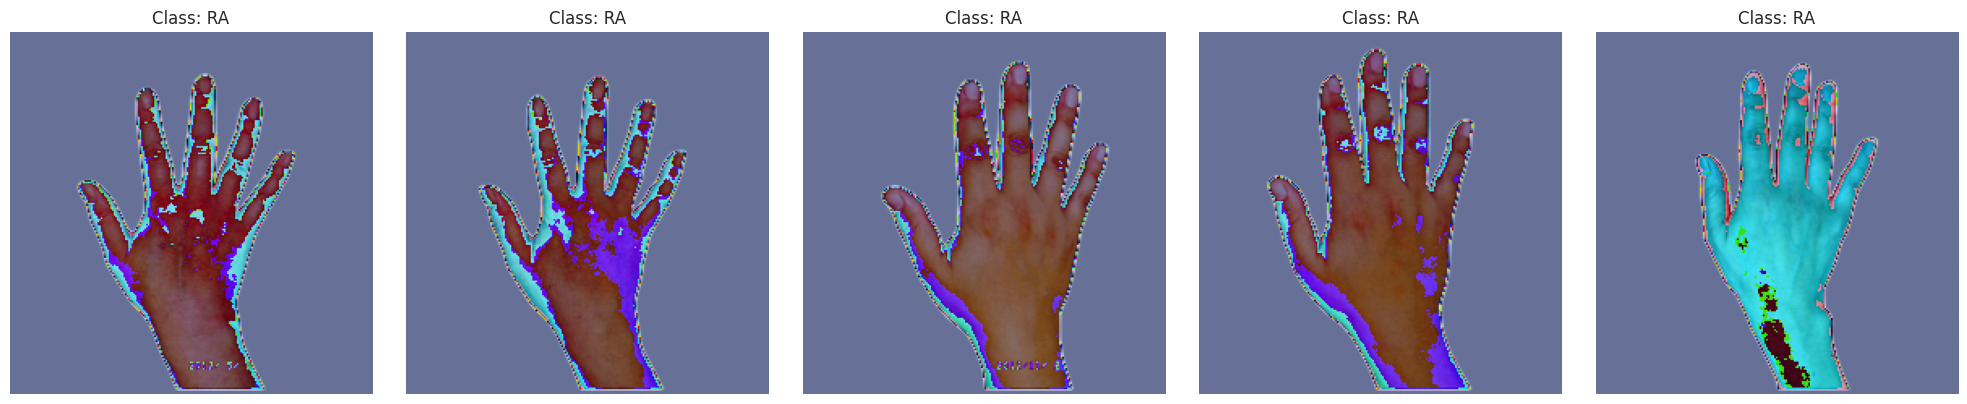

31354

In [ ]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.1
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch

# 1. 予測と確信度の取得
def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    image_paths = []  # 画像のパスまたは画像自体を保存

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            image_paths.extend(images.cpu())  # または元の画像パス

    return np.array(predictions), np.array(true_labels), np.array(confidences), image_paths

# 2. 混同行列の作成と可視化
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. 誤分類サンプルの分析
def analyze_misclassifications(true_labels, predictions, confidences, image_paths, class_names):
    # 誤分類のインデックスを取得
    misclassified_idx = np.where(predictions != true_labels)[0]

    # 確信度でソート
    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    # 上位の誤分類ケースを表示
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < len(sorted_idx):
            mis_idx = sorted_idx[idx]
            image = image_paths[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. 確信度分布の分析
def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(10, 6))

    # 正解と不正解の確信度を分離
    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メイン実行部分
def analyze_errors(model, val_loader, class_names, device):
    # 予測の取得
    predictions, true_labels, confidences, image_paths = get_predictions(model, val_loader, device)

    # 1. 全体の性能メトリクス
    print("Overall Accuracy:", np.mean(predictions == true_labels))

    # 2. 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 3. 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences,
                             image_paths, class_names)

    # 4. 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # 5. クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

<ipython-input-29-5f2c6321042d>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.815


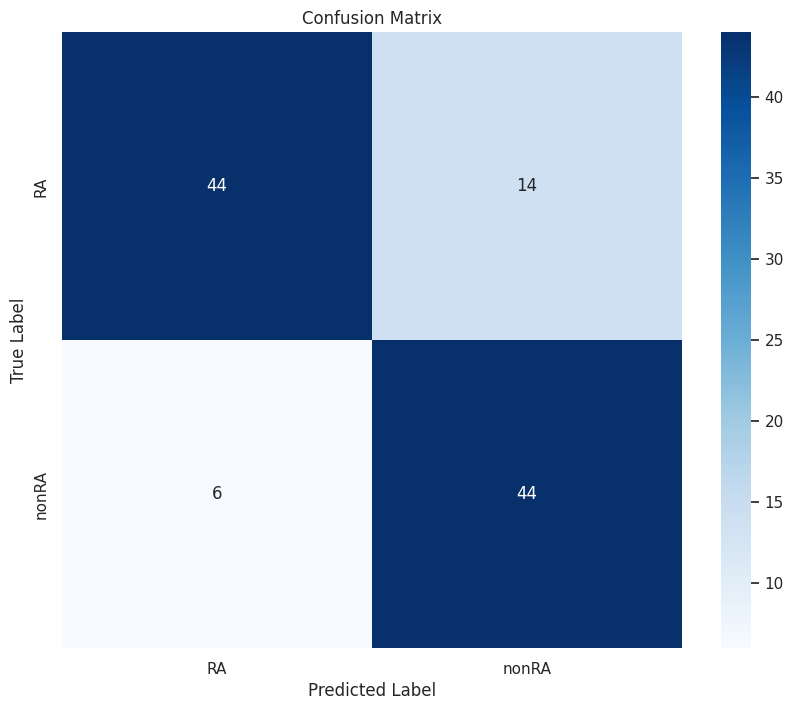

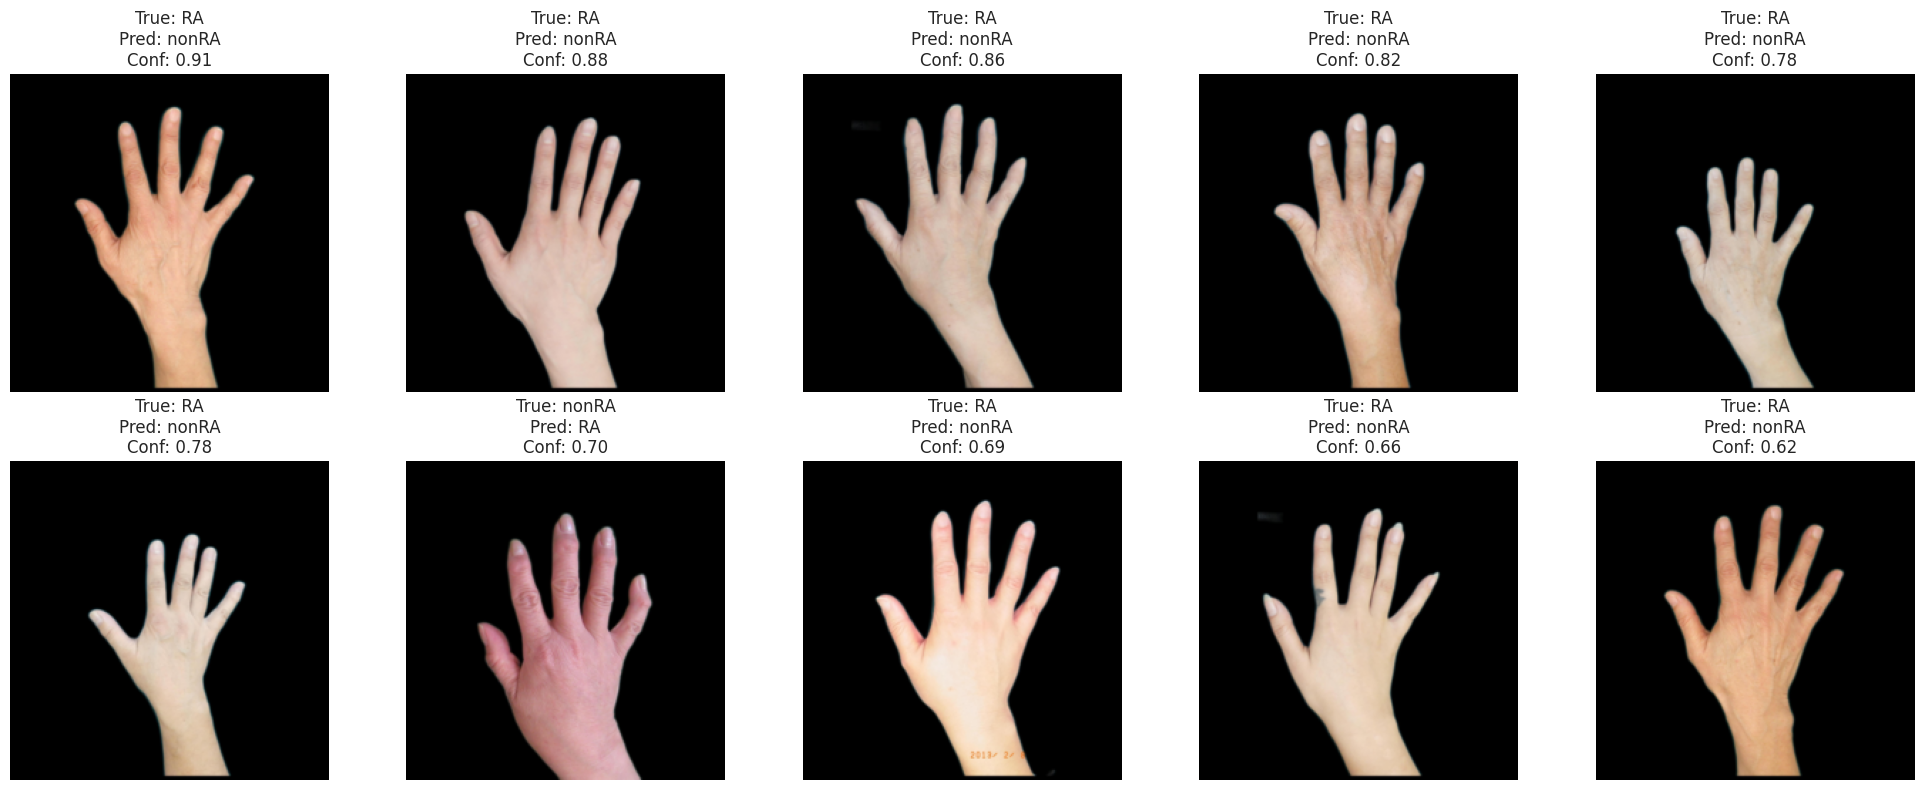

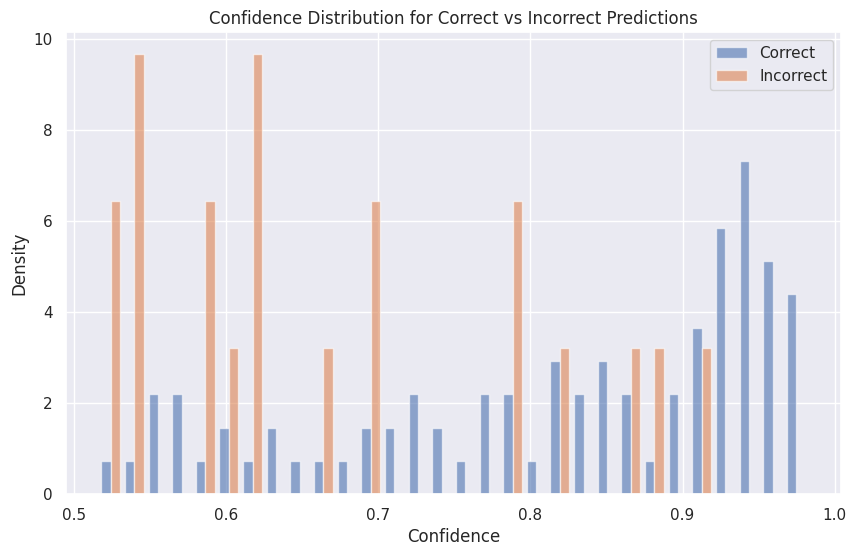


Class RA:
Accuracy: 0.759
Average confidence: 0.793
Samples: 58

Class nonRA:
Accuracy: 0.880
Average confidence: 0.791
Samples: 50


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(10, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()